# An analysis of the State of the Union speeches - Part 1

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import shelve

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

This is a "hollowed out" version of my complete analysis, leaving you a few results to check your progress:

In [2]:
# Addresses is a dataframe with all the basic data for the addresses:
addresses = pd.read_csv('./data/stateoftheunion1790-2017.txt', 
                        header=None, skiprows=10, parse_dates = [[2, 3]], nrows= 227) 
addresses.columns = ["date", "president", "title"]
addresses = addresses[["president", "title", "date"]]
addresses.head()

,president,title,date
0,George Washington,State of the Union Address,1790-01-08
1,George Washington,State of the Union Address,1790-12-08
2,George Washington,State of the Union Address,1791-10-25
3,George Washington,State of the Union Address,1792-11-06
4,George Washington,State of the Union Address,1793-12-03


Let's take a first look at a high-level summary of what we have so far:

In [3]:
# Describe the presidents data
addresses['president'].describe()

count                         227
unique                         42
top         Franklin D. Roosevelt
freq                           12
Name: president, dtype: object

Our data includes 227 state of union addresses and covers 42 presidents, so 3 presidents are missing since Donald Trump is our 45th president. FDR has the greatest number speeches at 12 addresses which makes sense since he was the only president that served 4 terms. Let's investigate which 3 presidents we are missing. 

In [4]:
#We can list out presidents in order and cross reference a complete list of presidents in order to figure out which ones are missing.
pd.Series(addresses['president'].unique(), index = list(range(1, 43)))

1           George Washington
2                  John Adams
3            Thomas Jefferson
4               James Madison
5                James Monroe
6           John Quincy Adams
7              Andrew Jackson
8            Martin van Buren
9                  John Tyler
10                 James Polk
11             Zachary Taylor
12           Millard Fillmore
13            Franklin Pierce
14             James Buchanan
15            Abraham Lincoln
16             Andrew Johnson
17           Ulysses S. Grant
18        Rutherford B. Hayes
19          Chester A. Arthur
20           Grover Cleveland
21          Benjamin Harrison
22           William McKinley
23         Theodore Roosevelt
24            William H. Taft
25             Woodrow Wilson
26             Warren Harding
27            Calvin Coolidge
28             Herbert Hoover
29      Franklin D. Roosevelt
30            Harry S. Truman
31       Dwight D. Eisenhower
32            John F. Kennedy
33          Lyndon B. Johnson
34        

John Tyler was the 10th president, not the 9th. We're missing William Henry Harrison. So, the reason we are missing William Henry Harrison's speech is because he only held 31 days of presidency before he got pneunomia and died.

Chester Arthur was the 21st president not the 19th, we're missing James A. Garfield. James A. Garfield was assasinated 4 months into his presidency and died a month later. 

And the finally we are missing Grover Cleveland's non-consecutive term since Cleveland was the 22nd and the 24th president.

Let's find the dates of the first and last address, and how much time has passed between those:

In [5]:
# This is roughly the number of years between the first and last address:
import calendar

#Let first find the min and max dates in the addresses dataframe
max = np.max(addresses['date'])
min = np.min(addresses['date'])

#We'll write a function that converts a date format into decimal years
def fractional_year(f_date):
    beg_yr = pd.datetime(f_date.year, 1, 1)
    days_passed = (f_date - beg_yr).days + 1
    if calendar.isleap(f_date.year):
        return f_date.year + days_passed/366
    else:
        return f_date.year + days_passed/365

#Now let's convert the max and min dates into decimal years and take their difference
fractional_year(max) - fractional_year(min)

227.13698630136992

Let's see during which months are the speeches most frequently delivered:

In [6]:
# This is a count of the number of addresses delivered on any given month

#alter addresses df to include all months and a Address Count column
if addresses.shape[0] < 239:
    addresses["Addresses Count"] = 1
    for i in range(1, 13):
        addresses.loc[addresses.shape[0]+(i-1)] = [np.nan, np.nan, pd.to_datetime('2018-'+ str(i) + '-1'), 0]

#create a acounts series using groupby date and aggregating on the sum of addresses count
acounts = addresses.groupby(addresses['date'].dt.strftime('%B'))['Addresses Count'].sum()

#reorder acounts series so its monthly chronological
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
acounts = acounts.reindex([months])

acounts

date
January       75
February      12
March          0
April          0
May            0
June           0
July           0
August         0
September      2
October        3
November      11
December     124
Name: Addresses Count, dtype: int64

In [7]:
#return addresses df to original
if addresses.shape[0] > 227:
    addresses = addresses[:-12]
    addresses = addresses.drop('Addresses Count', axis=1)
    
addresses.shape

(227, 3)

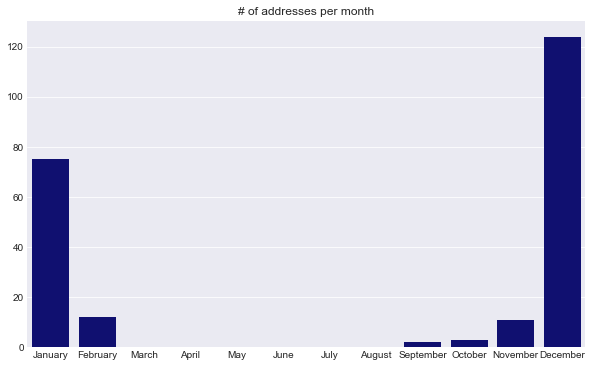

In [8]:
#And this is a plot of these:
sns.set_style("darkgrid")

w = pd.DataFrame({'Months': months, 'Count':acounts }, columns = ['Months', 'Count'])

#Plot count of speeches across months
fig, ax = plt.subplots(1, 1)
ax = sns.barplot(data = w, x = w.Months, y = w.Count, color = 'navy');
ax.set_title("# of addresses per month")
ax.set_ylabel('')    
ax.set_xlabel('')
    
plt.savefig('fig/addresses_month.png');

Let's look at the distribution of differences between successive speeches:

Where is the largest gap? We can ask the `ddiff` series for its location:

In [9]:
# This is the index of the largest gap:
dates = addresses['date']

# Find the difference between subsequent speeches
ddiff = pd.Series([dates[i] - dates[i-1] for i in range(1, dates.shape[0])], 
                  index = [i for i in range(1, 227)])

#Find the id of the greatest distance
dgap = ddiff.idxmax(axis=0)

#Return the id
dgap

104

Let's look at the dates around this index:

In [10]:
dates[dgap-2 : dgap+2]

102   1891-12-09
103   1892-12-06
104   1897-12-06
105   1898-12-05
Name: date, dtype: datetime64[ns]

As well as a plot of these times:

In [11]:
#We'll first create a series of speech numbers with date as the index
dates = pd.Series(list(range(0, 227)), index = addresses.date)

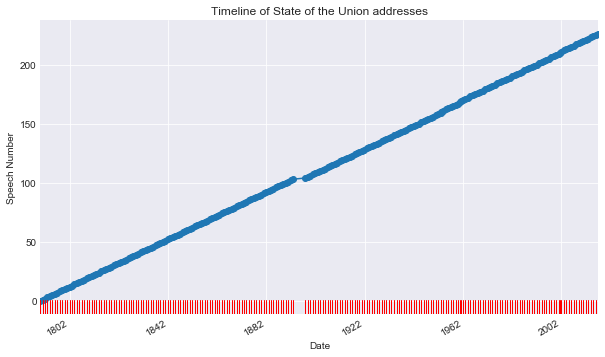

In [12]:
# A plot of the times, along with 'rug' markers on the x axis.
f, ax = plt.subplots(1, 1)

#Plot the dates on the x axis and speech number on the y axis
dates.plot(ax = ax, marker = 'o' );

#Add a rug plot of the distribution of dates
sns.rugplot(addresses.date, color = 'red');

ax.set_title("Timeline of State of the Union addresses")
ax.set_ylabel('Speech Number')    
ax.set_xlabel('Date')

f.savefig('fig/timeline.png')

What happened at that gap?

So the gap occured from 1893-1897 which was Grover Cleveland's second non-consecutive term. Cleveland did deliver hand written state of the union addresses for each of these 4 years. Quickly examing our data, there doesn't seem to be any issues with formatting. It seems like our dataframe is missing these specches and Cleveland's entire second term.

## Intermediate results

Let's save some intermediate results for further analysis. This lets us work on subsequent notebooks  without rerunning this one.  We use the Pandas HDF5 support for efficient and type-safe serialization of data frames, and the python builtin [shelve](https://docs.python.org/3/library/shelve.html) module for simple Python variables.  We'll create for each notebook variable stores with the notebook number, one for dataframes (`df1.h5`, `df2.h5`, etc.) and one for python variables (`vars1.db`, `vars2.db`, etc.).  These will all go into the `results/` subdirectory.

In [13]:
with open('./data/stateoftheunion1790-2017.txt') as f:
        text = f.read()
speeches = []
pointer = 1

while len(speeches) < 227:
    start = text.find('***', pointer+5)
    end = text.find('***', start+10)
    speeches.append(text[start+3:end])
    pointer = start
    

In [14]:
addresses.to_hdf('results/df1.h5', 'addresses')
with shelve.open('results/vars1') as db:
    db['speeches'] = speeches